In [2]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Seed for reproducibility
np.random.seed(42)

# Simulate daily precipitation for 12 months, 30 days each
months = np.repeat(np.arange(1, 13), 30)
precip = np.random.normal(5, 2, 360)  # average 5mm, std dev 2mm

In [4]:
april_indices = (months == 4)
precip[april_indices] += np.random.normal(0.5, 0.5, april_indices.sum()) # add extra rain (average, std dev)

# Create table
weather = Table().with_columns(
    "Month", months,
    "Precipitation", precip
)

In [5]:
weather.group("Month",np.mean)

Month,Precipitation mean
1,4.62371
2,4.75768
3,5.02577
4,5.57358
5,4.81008
6,5.55757
7,5.13118
8,5.09607
9,4.71314
10,5.21433


#### Null: April’s average precipitation is not significantly different from other months — the difference is due to chance.

#### Alternate: April’s average precipitation is higher than other months.

In [6]:
# Compare April to all other months
april = weather.where("Month", 4)
non_april = weather.where("Month", are.not_equal_to(4))

# Observed difference
observed_diff = april.column("Precipitation").mean() - non_april.column("Precipitation").mean()
print("Observed Difference (April - Other Months):", observed_diff)

Observed Difference (April - Other Months): 0.566293350158


In [7]:
# Permutation test
def permutation_sample():
    shuffled_labels = np.random.permutation(weather.column("Month"))
    shuffled = weather.with_column("Shuffled Month", shuffled_labels)
    april_shuffled = shuffled.where("Shuffled Month", 4)
    other_shuffled = shuffled.where("Shuffled Month", are.not_equal_to(4))
    return april_shuffled.column("Precipitation").mean() - other_shuffled.column("Precipitation").mean()

simulated_diffs = [permutation_sample() for _ in range(1000)]

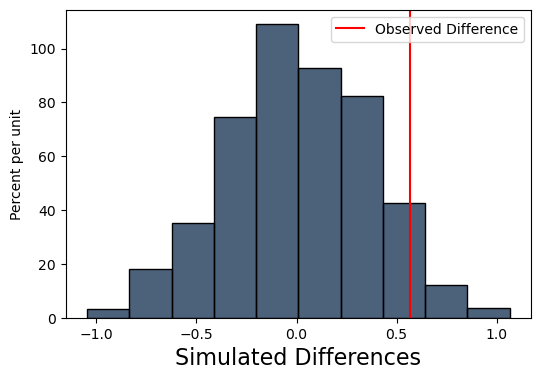

In [8]:
# Plot
Table().with_column("Simulated Differences", simulated_diffs).hist()
plt.axvline(observed_diff, color='red', label='Observed Difference')
plt.legend()
plt.show()

In [9]:
# Empirical p-value
p_val = np.count_nonzero(np.array(simulated_diffs) >= observed_diff) / 1000
print("Empirical p-value:", p_val)

Empirical p-value: 0.06


If p < 0.05: "We have evidence that April was unusually rainy."

Else: "We don't have enough evidence to say April was different."

## Your usual one sample test

In [65]:
# Step 1: Calculate April's mean
april_precip = weather.where("Month", 4).column("Precipitation")
april_mean = np.mean(april_precip)

print("April Mean Precipitation:", april_mean)

April Mean Precipitation: 5.57358307508


In [73]:
# Step 2: Build null distribution
# Sample 30 days at random (without regard to month), repeat
simulated_means = []
for _ in range(1000):
    sample = weather.sample(30)
    simulated_means.append(sample.column("Precipitation").mean())

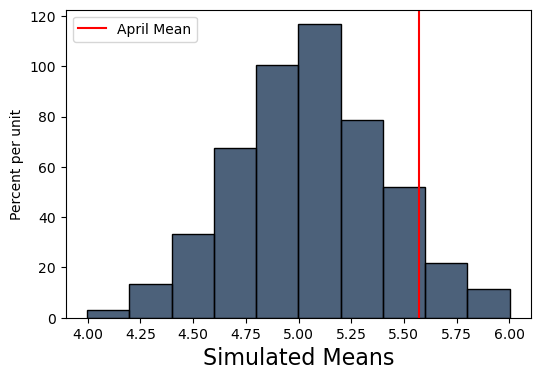

In [74]:
# Step 3: Plot
Table().with_column("Simulated Means", simulated_means).hist()
plt.axvline(april_mean, color='red', label='April Mean')
plt.legend()
plt.show()

In [75]:
# Step 4: Compute empirical p-value (one-sided: April mean is high)
p_val = np.count_nonzero(np.array(simulated_means) >= april_mean) / 1000
print("Empirical p-value:", p_val)

Empirical p-value: 0.075


#### If p_val < 0.05, April is significantly rainier than we’d expect from a random 30-day period.